In [41]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import statsmodels.api as sm
import prophet
from sklearn.metrics import mean_absolute_percentage_error

In [32]:
prophet.Prophet()

In [33]:
df = pd.read_csv('variable_selected_county_dataset.csv', index_col=0)

In [34]:
data = pd.read_csv('variable_selected_county_dataset.csv').iloc[:, 1:]

In [35]:
def difference(df):
    df['incremental_cases'] = df['incremental_cases'].diff().fillna(df['incremental_cases'])
    return df

chicago = data[data['entity'] == 'California-Los Angeles'].loc[:, ['date', 'incremental_cases']]
chicago['incremental_cases'] = chicago['incremental_cases'].astype('int')
chicago['date'] = pd.to_datetime(chicago['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = chicago.iloc[:230, :]
test = chicago.iloc[230:, :]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

stationary_test(train.incremental_cases)

(-1.8029508843492845, 0.37899764874321873)

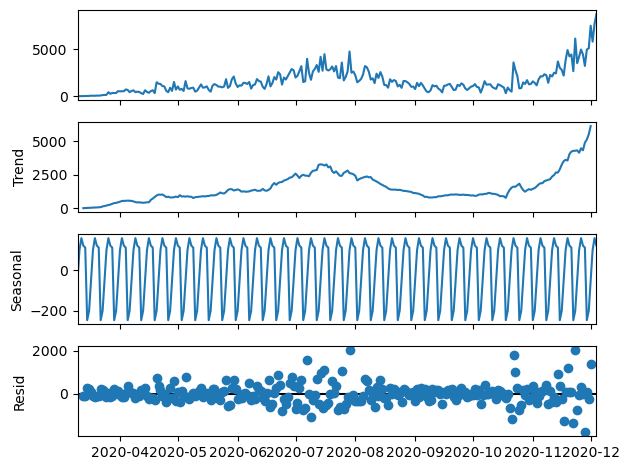

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

analysis = chicago.set_index('date').copy()


decompose_result_mult = seasonal_decompose(analysis)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

In [37]:
for x in decompose_result_mult.seasonal:
    print(x)

-45.92536360205529
100.11588817603855
159.2703283304787
122.01824542050105
112.26636572125295
-247.22987488025086
-200.51558916596514
-45.92536360205529
100.11588817603855
159.2703283304787
122.01824542050105
112.26636572125295
-247.22987488025086
-200.51558916596514
-45.92536360205529
100.11588817603855
159.2703283304787
122.01824542050105
112.26636572125295
-247.22987488025086
-200.51558916596514
-45.92536360205529
100.11588817603855
159.2703283304787
122.01824542050105
112.26636572125295
-247.22987488025086
-200.51558916596514
-45.92536360205529
100.11588817603855
159.2703283304787
122.01824542050105
112.26636572125295
-247.22987488025086
-200.51558916596514
-45.92536360205529
100.11588817603855
159.2703283304787
122.01824542050105
112.26636572125295
-247.22987488025086
-200.51558916596514
-45.92536360205529
100.11588817603855
159.2703283304787
122.01824542050105
112.26636572125295
-247.22987488025086
-200.51558916596514
-45.92536360205529
100.11588817603855
159.2703283304787
122.01

In [38]:
arimaModel = chicago[['date', 'incremental_cases']]
arimaModel.rename(columns={"date": "ds", "incremental_cases": "y"}, inplace=True)
train = arimaModel.head(int(0.85*len(arimaModel))+1)
test = arimaModel.tail(int(0.15*len(arimaModel)))

20:13:29 - cmdstanpy - INFO - Chain [1] start processing
20:13:29 - cmdstanpy - INFO - Chain [1] done processing


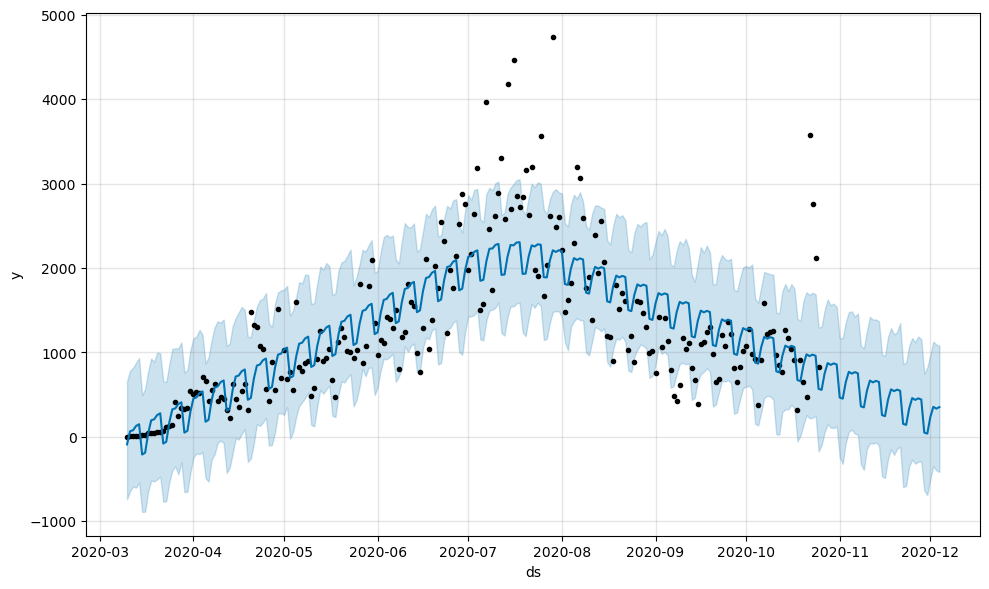

In [39]:
baseModel = prophet.Prophet().fit(train)
future = baseModel.make_future_dataframe(periods=40)
forecast = baseModel.predict(future)
baseModel.plot(forecast);

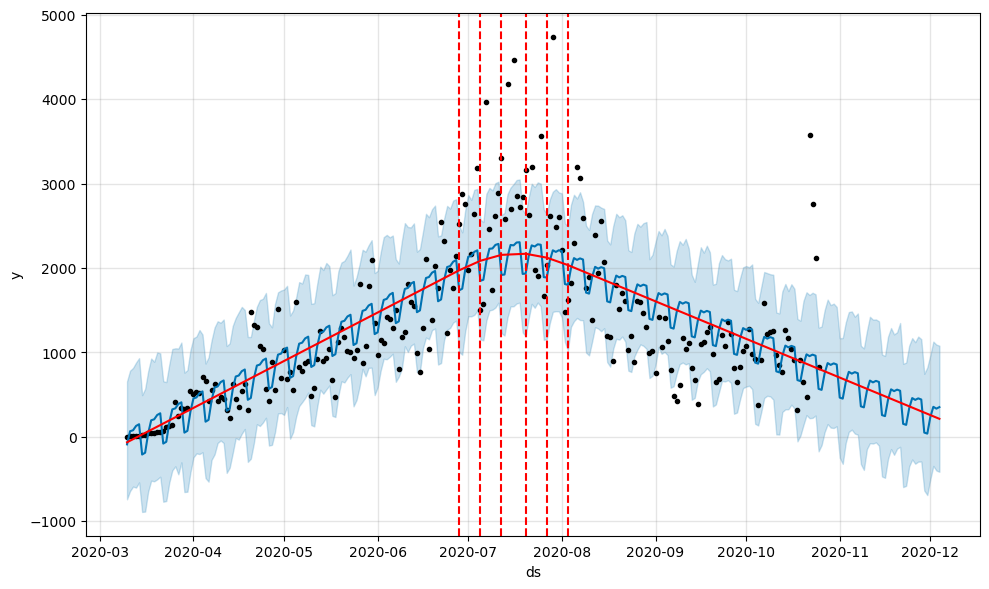

In [40]:
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = baseModel.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), baseModel, forecast)

In [42]:
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

In [43]:
dfToUse = df[df['entity'] == 'California-Los Angeles']
dfToUse.rename(columns={"date": "ds", "incremental_cases": "y"}, inplace=True)
foo = dfToUse.copy().drop(labels=['ds','entity','y','cases'],axis=1)
non_floats = []
for col in foo:
    if foo[col].dtypes == "float64":
        non_floats.append(col)
foo.drop(labels=non_floats,axis=1,inplace=True)
    
dummyDF = pd.get_dummies(dfToUse, columns=foo.columns.tolist())

In [44]:
toDrop = dummyDF.columns[dummyDF.nunique() == 1].tolist()
#toDrop.pop()
#dfToUse.drop(labels=toDrop, axis=1, inplace=True)
dummyDF.drop(labels=toDrop, axis=1, inplace=True)

In [45]:
dummyDF.ds

190     2020-03-10
201     2020-03-11
213     2020-03-12
225     2020-03-13
237     2020-03-14
           ...    
3369    2020-11-30
3381    2020-12-01
3393    2020-12-02
3405    2020-12-03
3417    2020-12-04
Name: ds, Length: 270, dtype: object

In [46]:
train = dummyDF[dummyDF['ds'] < '2020-10-26'].sort_values(by=['ds']).reset_index().drop(labels=['index'],axis=1)
test = dummyDF[dummyDF['ds'] >= '2020-10-26']

In [47]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

#train.reset_index(inplace=True)

n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

changepoint_prior_scale = [0.001, 0.01, 0.1, 0.5]
seasonality_prior_scale =  [0.01, 0.1, 1.0, 10.0]
holidays_prior_scale = [0.01, 0.1, 1.0, 10.0]
seasonality_mode = ['additive', 'multiplicative']

best_score, best_cfg = float("inf"), None
    
for h in holidays_prior_scale:
    for c in changepoint_prior_scale:
        for s in seasonality_prior_scale:
            for m in seasonality_mode:
                avg = 0
                print((h,c,s,m))
                for train_index, val_index in tscv.split(train):
                    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
                    val_data.fillna(0, inplace=True)
                    train_data.fillna(0, inplace=True)
                    model=prophet.Prophet(holidays=events, holidays_prior_scale=h, changepoint_prior_scale=c, seasonality_prior_scale=s,
                                         seasonality_mode = m,yearly_seasonality=True, weekly_seasonality=True)
                    for ii in train_data.columns:
                        if ii == 'index':
                            continue
                        if ii == 'ds':
                            continue
                        if ii == 'cases':
                            continue
                        if ii == 'y':
                            continue
                        model.add_regressor(ii)
                    model.add_country_holidays(country_name='US')
                    model.fit(train_data)
                    #future = model.make_future_dataframe(periods=val_data.shape[0])
                    #future = future[future['ds'] > train_data.ds.iloc[-1]]
                    forecast = model.predict(val_data)
                    mse = mean_squared_error(val_data.y, forecast.yhat)
                    avg += mse
                if avg < best_score:
                    best_score, best_cfg = avg, (h,c,s,m)

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

20:14:03 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.001, 0.01, 'additive')


20:14:04 - cmdstanpy - INFO - Chain [1] done processing
20:14:04 - cmdstanpy - INFO - Chain [1] start processing
20:14:04 - cmdstanpy - INFO - Chain [1] done processing
20:14:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:14:04 - cmdstanpy - INFO - Chain [1] start processing
20:14:07 - cmdstanpy - INFO - Chain [1] done processing
20:14:07 - cmdstanpy - INFO - Chain [1] start processing
20:14:07 - cmdstanpy - INFO - Chain [1] done processing
20:14:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:14:07 - cmdstanpy - INFO - Chain [1] start processing
20:14:09 - cmdstanpy - INFO - Chain [1] done processing
20:14:09 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.001, 0.01, 'multiplicative')


20:14:09 - cmdstanpy - INFO - Chain [1] done processing
20:14:09 - cmdstanpy - INFO - Chain [1] start processing
20:14:09 - cmdstanpy - INFO - Chain [1] done processing
20:14:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:14:09 - cmdstanpy - INFO - Chain [1] start processing
20:14:10 - cmdstanpy - INFO - Chain [1] done processing
20:14:10 - cmdstanpy - INFO - Chain [1] start processing
20:14:10 - cmdstanpy - INFO - Chain [1] done processing
20:14:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:14:10 - cmdstanpy - INFO - Chain [1] start processing
20:14:12 - cmdstanpy - INFO - Chain [1] done processing
20:14:12 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.001, 0.1, 'additive')


20:14:12 - cmdstanpy - INFO - Chain [1] done processing
20:14:12 - cmdstanpy - INFO - Chain [1] start processing
20:14:12 - cmdstanpy - INFO - Chain [1] done processing
20:14:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:14:12 - cmdstanpy - INFO - Chain [1] start processing
20:14:13 - cmdstanpy - INFO - Chain [1] done processing
20:14:13 - cmdstanpy - INFO - Chain [1] start processing
20:14:13 - cmdstanpy - INFO - Chain [1] done processing
20:14:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:14:13 - cmdstanpy - INFO - Chain [1] start processing
20:14:13 - cmdstanpy - INFO - Chain [1] done processing
20:14:13 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.001, 0.1, 'multiplicative')


20:14:13 - cmdstanpy - INFO - Chain [1] done processing
20:14:14 - cmdstanpy - INFO - Chain [1] start processing
20:14:14 - cmdstanpy - INFO - Chain [1] done processing
20:14:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:14:14 - cmdstanpy - INFO - Chain [1] start processing
20:14:18 - cmdstanpy - INFO - Chain [1] done processing
20:14:18 - cmdstanpy - INFO - Chain [1] start processing
20:14:18 - cmdstanpy - INFO - Chain [1] done processing
20:14:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:14:18 - cmdstanpy - INFO - Chain [1] start processing
20:14:18 - cmdstanpy - INFO - Chain [1] done processing
20:14:18 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.001, 1.0, 'additive')


20:14:19 - cmdstanpy - INFO - Chain [1] done processing
20:14:19 - cmdstanpy - INFO - Chain [1] start processing
20:14:19 - cmdstanpy - INFO - Chain [1] done processing
20:14:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:14:19 - cmdstanpy - INFO - Chain [1] start processing
20:14:20 - cmdstanpy - INFO - Chain [1] done processing
20:14:20 - cmdstanpy - INFO - Chain [1] start processing
20:14:20 - cmdstanpy - INFO - Chain [1] done processing
20:14:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:14:20 - cmdstanpy - INFO - Chain [1] start processing
20:14:21 - cmdstanpy - INFO - Chain [1] done processing
20:14:21 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.001, 1.0, 'multiplicative')


20:14:24 - cmdstanpy - INFO - Chain [1] done processing
20:14:25 - cmdstanpy - INFO - Chain [1] start processing
20:14:25 - cmdstanpy - INFO - Chain [1] done processing
20:14:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:14:25 - cmdstanpy - INFO - Chain [1] start processing
20:14:28 - cmdstanpy - INFO - Chain [1] done processing
20:14:28 - cmdstanpy - INFO - Chain [1] start processing
20:14:28 - cmdstanpy - INFO - Chain [1] done processing
20:14:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:14:28 - cmdstanpy - INFO - Chain [1] start processing
20:14:34 - cmdstanpy - INFO - Chain [1] done processing
20:14:34 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.001, 10.0, 'additive')


20:15:14 - cmdstanpy - INFO - Chain [1] done processing
20:15:14 - cmdstanpy - INFO - Chain [1] start processing
20:15:14 - cmdstanpy - INFO - Chain [1] done processing
20:15:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:15:14 - cmdstanpy - INFO - Chain [1] start processing
20:15:14 - cmdstanpy - INFO - Chain [1] done processing
20:15:14 - cmdstanpy - INFO - Chain [1] start processing
20:15:14 - cmdstanpy - INFO - Chain [1] done processing
20:15:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:15:14 - cmdstanpy - INFO - Chain [1] start processing
20:15:15 - cmdstanpy - INFO - Chain [1] done processing
20:15:15 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.001, 10.0, 'multiplicative')


20:15:20 - cmdstanpy - INFO - Chain [1] done processing
20:15:20 - cmdstanpy - INFO - Chain [1] start processing
20:15:20 - cmdstanpy - INFO - Chain [1] done processing
20:15:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:15:20 - cmdstanpy - INFO - Chain [1] start processing
20:15:40 - cmdstanpy - INFO - Chain [1] done processing
20:15:40 - cmdstanpy - INFO - Chain [1] start processing
20:15:40 - cmdstanpy - INFO - Chain [1] done processing
20:15:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:15:40 - cmdstanpy - INFO - Chain [1] start processing
20:16:07 - cmdstanpy - INFO - Chain [1] done processing
20:16:07 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.01, 0.01, 'additive')


20:16:08 - cmdstanpy - INFO - Chain [1] done processing
20:16:08 - cmdstanpy - INFO - Chain [1] start processing
20:16:08 - cmdstanpy - INFO - Chain [1] done processing
20:16:08 - cmdstanpy - INFO - Chain [1] start processing
20:16:08 - cmdstanpy - INFO - Chain [1] done processing
20:16:08 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.01, 0.01, 'multiplicative')


20:16:08 - cmdstanpy - INFO - Chain [1] done processing
20:16:08 - cmdstanpy - INFO - Chain [1] start processing
20:16:08 - cmdstanpy - INFO - Chain [1] done processing
20:16:08 - cmdstanpy - INFO - Chain [1] start processing
20:16:08 - cmdstanpy - INFO - Chain [1] done processing
20:16:08 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.01, 0.1, 'additive')


20:16:08 - cmdstanpy - INFO - Chain [1] done processing
20:16:09 - cmdstanpy - INFO - Chain [1] start processing
20:16:09 - cmdstanpy - INFO - Chain [1] done processing
20:16:09 - cmdstanpy - INFO - Chain [1] start processing
20:16:09 - cmdstanpy - INFO - Chain [1] done processing
20:16:09 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.01, 0.1, 'multiplicative')


20:16:09 - cmdstanpy - INFO - Chain [1] done processing
20:16:09 - cmdstanpy - INFO - Chain [1] start processing
20:16:09 - cmdstanpy - INFO - Chain [1] done processing
20:16:09 - cmdstanpy - INFO - Chain [1] start processing
20:16:09 - cmdstanpy - INFO - Chain [1] done processing
20:16:09 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.01, 1.0, 'additive')


20:16:09 - cmdstanpy - INFO - Chain [1] done processing
20:16:09 - cmdstanpy - INFO - Chain [1] start processing
20:16:09 - cmdstanpy - INFO - Chain [1] done processing
20:16:09 - cmdstanpy - INFO - Chain [1] start processing
20:16:09 - cmdstanpy - INFO - Chain [1] done processing
20:16:09 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.01, 1.0, 'multiplicative')


20:16:10 - cmdstanpy - INFO - Chain [1] done processing
20:16:10 - cmdstanpy - INFO - Chain [1] start processing
20:16:10 - cmdstanpy - INFO - Chain [1] done processing
20:16:10 - cmdstanpy - INFO - Chain [1] start processing
20:16:10 - cmdstanpy - INFO - Chain [1] done processing
20:16:10 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.01, 10.0, 'additive')


20:16:11 - cmdstanpy - INFO - Chain [1] done processing
20:16:11 - cmdstanpy - INFO - Chain [1] start processing
20:16:11 - cmdstanpy - INFO - Chain [1] done processing
20:16:11 - cmdstanpy - INFO - Chain [1] start processing
20:16:11 - cmdstanpy - INFO - Chain [1] done processing
20:16:11 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.01, 10.0, 'multiplicative')


20:16:13 - cmdstanpy - INFO - Chain [1] done processing
20:16:13 - cmdstanpy - INFO - Chain [1] start processing
20:16:13 - cmdstanpy - INFO - Chain [1] done processing
20:16:13 - cmdstanpy - INFO - Chain [1] start processing
20:16:13 - cmdstanpy - INFO - Chain [1] done processing
20:16:13 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.1, 0.01, 'additive')


20:16:14 - cmdstanpy - INFO - Chain [1] done processing
20:16:14 - cmdstanpy - INFO - Chain [1] start processing
20:16:14 - cmdstanpy - INFO - Chain [1] done processing
20:16:14 - cmdstanpy - INFO - Chain [1] start processing
20:16:14 - cmdstanpy - INFO - Chain [1] done processing
20:16:14 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.1, 0.01, 'multiplicative')


20:16:14 - cmdstanpy - INFO - Chain [1] done processing
20:16:14 - cmdstanpy - INFO - Chain [1] start processing
20:16:15 - cmdstanpy - INFO - Chain [1] done processing
20:16:15 - cmdstanpy - INFO - Chain [1] start processing
20:16:15 - cmdstanpy - INFO - Chain [1] done processing
20:16:15 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.1, 0.1, 'additive')


20:16:15 - cmdstanpy - INFO - Chain [1] done processing
20:16:15 - cmdstanpy - INFO - Chain [1] start processing
20:16:15 - cmdstanpy - INFO - Chain [1] done processing
20:16:15 - cmdstanpy - INFO - Chain [1] start processing
20:16:15 - cmdstanpy - INFO - Chain [1] done processing
20:16:15 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.1, 0.1, 'multiplicative')


20:16:16 - cmdstanpy - INFO - Chain [1] done processing
20:16:16 - cmdstanpy - INFO - Chain [1] start processing
20:16:16 - cmdstanpy - INFO - Chain [1] done processing
20:16:16 - cmdstanpy - INFO - Chain [1] start processing
20:16:16 - cmdstanpy - INFO - Chain [1] done processing
20:16:16 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.1, 1.0, 'additive')


20:16:16 - cmdstanpy - INFO - Chain [1] done processing
20:16:16 - cmdstanpy - INFO - Chain [1] start processing
20:16:16 - cmdstanpy - INFO - Chain [1] done processing
20:16:16 - cmdstanpy - INFO - Chain [1] start processing
20:16:16 - cmdstanpy - INFO - Chain [1] done processing
20:16:16 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.1, 1.0, 'multiplicative')


20:16:17 - cmdstanpy - INFO - Chain [1] done processing
20:16:17 - cmdstanpy - INFO - Chain [1] start processing
20:16:17 - cmdstanpy - INFO - Chain [1] done processing
20:16:17 - cmdstanpy - INFO - Chain [1] start processing
20:16:17 - cmdstanpy - INFO - Chain [1] done processing
20:16:17 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.1, 10.0, 'additive')


20:16:18 - cmdstanpy - INFO - Chain [1] done processing
20:16:18 - cmdstanpy - INFO - Chain [1] start processing
20:16:18 - cmdstanpy - INFO - Chain [1] done processing
20:16:18 - cmdstanpy - INFO - Chain [1] start processing
20:16:18 - cmdstanpy - INFO - Chain [1] done processing
20:16:18 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.1, 10.0, 'multiplicative')


20:16:19 - cmdstanpy - INFO - Chain [1] done processing
20:16:19 - cmdstanpy - INFO - Chain [1] start processing
20:16:19 - cmdstanpy - INFO - Chain [1] done processing
20:16:19 - cmdstanpy - INFO - Chain [1] start processing
20:16:19 - cmdstanpy - INFO - Chain [1] done processing
20:16:19 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.5, 0.01, 'additive')


20:16:20 - cmdstanpy - INFO - Chain [1] done processing
20:16:20 - cmdstanpy - INFO - Chain [1] start processing
20:16:20 - cmdstanpy - INFO - Chain [1] done processing
20:16:20 - cmdstanpy - INFO - Chain [1] start processing
20:16:20 - cmdstanpy - INFO - Chain [1] done processing
20:16:20 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.5, 0.01, 'multiplicative')


20:16:21 - cmdstanpy - INFO - Chain [1] done processing
20:16:21 - cmdstanpy - INFO - Chain [1] start processing
20:16:21 - cmdstanpy - INFO - Chain [1] done processing
20:16:21 - cmdstanpy - INFO - Chain [1] start processing
20:16:21 - cmdstanpy - INFO - Chain [1] done processing
20:16:21 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.5, 0.1, 'additive')


20:16:22 - cmdstanpy - INFO - Chain [1] done processing
20:16:22 - cmdstanpy - INFO - Chain [1] start processing
20:16:22 - cmdstanpy - INFO - Chain [1] done processing
20:16:22 - cmdstanpy - INFO - Chain [1] start processing
20:16:22 - cmdstanpy - INFO - Chain [1] done processing
20:16:22 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.5, 0.1, 'multiplicative')


20:16:23 - cmdstanpy - INFO - Chain [1] done processing
20:16:23 - cmdstanpy - INFO - Chain [1] start processing
20:16:23 - cmdstanpy - INFO - Chain [1] done processing
20:16:23 - cmdstanpy - INFO - Chain [1] start processing
20:16:23 - cmdstanpy - INFO - Chain [1] done processing
20:16:23 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.5, 1.0, 'additive')


20:16:23 - cmdstanpy - INFO - Chain [1] done processing
20:16:23 - cmdstanpy - INFO - Chain [1] start processing
20:16:23 - cmdstanpy - INFO - Chain [1] done processing
20:16:23 - cmdstanpy - INFO - Chain [1] start processing
20:16:23 - cmdstanpy - INFO - Chain [1] done processing
20:16:23 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.5, 1.0, 'multiplicative')


20:16:25 - cmdstanpy - INFO - Chain [1] done processing
20:16:25 - cmdstanpy - INFO - Chain [1] start processing
20:16:25 - cmdstanpy - INFO - Chain [1] done processing
20:16:25 - cmdstanpy - INFO - Chain [1] start processing
20:16:25 - cmdstanpy - INFO - Chain [1] done processing
20:16:25 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.5, 10.0, 'additive')


20:16:25 - cmdstanpy - INFO - Chain [1] done processing
20:16:25 - cmdstanpy - INFO - Chain [1] start processing
20:16:25 - cmdstanpy - INFO - Chain [1] done processing
20:16:26 - cmdstanpy - INFO - Chain [1] start processing
20:16:26 - cmdstanpy - INFO - Chain [1] done processing
20:16:26 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.5, 10.0, 'multiplicative')


20:16:27 - cmdstanpy - INFO - Chain [1] done processing
20:16:27 - cmdstanpy - INFO - Chain [1] start processing
20:16:27 - cmdstanpy - INFO - Chain [1] done processing
20:16:27 - cmdstanpy - INFO - Chain [1] start processing
20:16:27 - cmdstanpy - INFO - Chain [1] done processing
20:16:27 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.001, 0.01, 'additive')


20:16:27 - cmdstanpy - INFO - Chain [1] done processing
20:16:27 - cmdstanpy - INFO - Chain [1] start processing
20:16:27 - cmdstanpy - INFO - Chain [1] done processing
20:16:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:16:27 - cmdstanpy - INFO - Chain [1] start processing
20:16:28 - cmdstanpy - INFO - Chain [1] done processing
20:16:28 - cmdstanpy - INFO - Chain [1] start processing
20:16:28 - cmdstanpy - INFO - Chain [1] done processing
20:16:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:16:28 - cmdstanpy - INFO - Chain [1] start processing
20:16:29 - cmdstanpy - INFO - Chain [1] done processing
20:16:29 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.001, 0.01, 'multiplicative')


20:16:29 - cmdstanpy - INFO - Chain [1] done processing
20:16:29 - cmdstanpy - INFO - Chain [1] start processing
20:16:29 - cmdstanpy - INFO - Chain [1] done processing
20:16:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:16:29 - cmdstanpy - INFO - Chain [1] start processing
20:16:38 - cmdstanpy - INFO - Chain [1] done processing
20:16:38 - cmdstanpy - INFO - Chain [1] start processing
20:16:38 - cmdstanpy - INFO - Chain [1] done processing
20:16:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:16:38 - cmdstanpy - INFO - Chain [1] start processing
20:17:48 - cmdstanpy - INFO - Chain [1] done processing
20:17:48 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.001, 0.1, 'additive')


20:17:48 - cmdstanpy - INFO - Chain [1] done processing
20:17:48 - cmdstanpy - INFO - Chain [1] start processing
20:17:48 - cmdstanpy - INFO - Chain [1] done processing
20:17:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:17:49 - cmdstanpy - INFO - Chain [1] start processing
20:17:49 - cmdstanpy - INFO - Chain [1] done processing
20:17:49 - cmdstanpy - INFO - Chain [1] start processing
20:17:49 - cmdstanpy - INFO - Chain [1] done processing
20:17:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:17:49 - cmdstanpy - INFO - Chain [1] start processing
20:17:50 - cmdstanpy - INFO - Chain [1] done processing
20:17:50 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.001, 0.1, 'multiplicative')


20:17:57 - cmdstanpy - INFO - Chain [1] done processing
20:17:57 - cmdstanpy - INFO - Chain [1] start processing
20:17:57 - cmdstanpy - INFO - Chain [1] done processing
20:17:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:17:57 - cmdstanpy - INFO - Chain [1] start processing
20:17:57 - cmdstanpy - INFO - Chain [1] done processing
20:17:58 - cmdstanpy - INFO - Chain [1] start processing
20:17:58 - cmdstanpy - INFO - Chain [1] done processing
20:17:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:17:58 - cmdstanpy - INFO - Chain [1] start processing
20:18:00 - cmdstanpy - INFO - Chain [1] done processing
20:18:00 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.001, 1.0, 'additive')


20:18:00 - cmdstanpy - INFO - Chain [1] done processing
20:18:00 - cmdstanpy - INFO - Chain [1] start processing
20:18:00 - cmdstanpy - INFO - Chain [1] done processing
20:18:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:18:00 - cmdstanpy - INFO - Chain [1] start processing
20:18:12 - cmdstanpy - INFO - Chain [1] done processing
20:18:12 - cmdstanpy - INFO - Chain [1] start processing
20:18:12 - cmdstanpy - INFO - Chain [1] done processing
20:18:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:18:12 - cmdstanpy - INFO - Chain [1] start processing
20:18:13 - cmdstanpy - INFO - Chain [1] done processing
20:18:13 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.001, 1.0, 'multiplicative')


20:18:13 - cmdstanpy - INFO - Chain [1] done processing
20:18:13 - cmdstanpy - INFO - Chain [1] start processing
20:18:13 - cmdstanpy - INFO - Chain [1] done processing
20:18:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:18:13 - cmdstanpy - INFO - Chain [1] start processing
20:18:14 - cmdstanpy - INFO - Chain [1] done processing
20:18:14 - cmdstanpy - INFO - Chain [1] start processing
20:18:14 - cmdstanpy - INFO - Chain [1] done processing
20:18:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:18:14 - cmdstanpy - INFO - Chain [1] start processing
20:18:19 - cmdstanpy - INFO - Chain [1] done processing
20:18:19 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.001, 10.0, 'additive')


20:18:46 - cmdstanpy - INFO - Chain [1] done processing
20:18:46 - cmdstanpy - INFO - Chain [1] start processing
20:18:46 - cmdstanpy - INFO - Chain [1] done processing
20:18:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:18:46 - cmdstanpy - INFO - Chain [1] start processing
20:18:51 - cmdstanpy - INFO - Chain [1] done processing
20:18:51 - cmdstanpy - INFO - Chain [1] start processing
20:18:51 - cmdstanpy - INFO - Chain [1] done processing
20:18:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:18:51 - cmdstanpy - INFO - Chain [1] start processing
20:18:53 - cmdstanpy - INFO - Chain [1] done processing
20:18:53 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.001, 10.0, 'multiplicative')


20:19:24 - cmdstanpy - INFO - Chain [1] done processing
20:19:24 - cmdstanpy - INFO - Chain [1] start processing
20:19:24 - cmdstanpy - INFO - Chain [1] done processing
20:19:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:19:24 - cmdstanpy - INFO - Chain [1] start processing
20:19:34 - cmdstanpy - INFO - Chain [1] done processing
20:19:35 - cmdstanpy - INFO - Chain [1] start processing
20:19:35 - cmdstanpy - INFO - Chain [1] done processing
20:19:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:19:35 - cmdstanpy - INFO - Chain [1] start processing
20:19:50 - cmdstanpy - INFO - Chain [1] done processing
20:19:50 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.01, 0.01, 'additive')


20:19:50 - cmdstanpy - INFO - Chain [1] done processing
20:19:50 - cmdstanpy - INFO - Chain [1] start processing
20:19:50 - cmdstanpy - INFO - Chain [1] done processing
20:19:51 - cmdstanpy - INFO - Chain [1] start processing
20:19:51 - cmdstanpy - INFO - Chain [1] done processing
20:19:51 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.01, 0.01, 'multiplicative')


20:19:51 - cmdstanpy - INFO - Chain [1] done processing
20:19:51 - cmdstanpy - INFO - Chain [1] start processing
20:19:51 - cmdstanpy - INFO - Chain [1] done processing
20:19:51 - cmdstanpy - INFO - Chain [1] start processing
20:19:51 - cmdstanpy - INFO - Chain [1] done processing
20:19:51 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.01, 0.1, 'additive')


20:19:52 - cmdstanpy - INFO - Chain [1] done processing
20:19:52 - cmdstanpy - INFO - Chain [1] start processing
20:19:52 - cmdstanpy - INFO - Chain [1] done processing
20:19:52 - cmdstanpy - INFO - Chain [1] start processing
20:19:52 - cmdstanpy - INFO - Chain [1] done processing
20:19:52 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.01, 0.1, 'multiplicative')


20:19:52 - cmdstanpy - INFO - Chain [1] done processing
20:19:52 - cmdstanpy - INFO - Chain [1] start processing
20:19:52 - cmdstanpy - INFO - Chain [1] done processing
20:19:52 - cmdstanpy - INFO - Chain [1] start processing
20:19:52 - cmdstanpy - INFO - Chain [1] done processing
20:19:52 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.01, 1.0, 'additive')


20:19:53 - cmdstanpy - INFO - Chain [1] done processing
20:19:53 - cmdstanpy - INFO - Chain [1] start processing
20:19:53 - cmdstanpy - INFO - Chain [1] done processing
20:19:53 - cmdstanpy - INFO - Chain [1] start processing
20:19:53 - cmdstanpy - INFO - Chain [1] done processing
20:19:53 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.01, 1.0, 'multiplicative')


20:19:53 - cmdstanpy - INFO - Chain [1] done processing
20:19:54 - cmdstanpy - INFO - Chain [1] start processing
20:19:54 - cmdstanpy - INFO - Chain [1] done processing
20:19:54 - cmdstanpy - INFO - Chain [1] start processing
20:19:54 - cmdstanpy - INFO - Chain [1] done processing
20:19:54 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.01, 10.0, 'additive')


20:19:54 - cmdstanpy - INFO - Chain [1] done processing
20:19:54 - cmdstanpy - INFO - Chain [1] start processing
20:19:54 - cmdstanpy - INFO - Chain [1] done processing
20:19:54 - cmdstanpy - INFO - Chain [1] start processing
20:19:54 - cmdstanpy - INFO - Chain [1] done processing
20:19:54 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.01, 10.0, 'multiplicative')


20:19:55 - cmdstanpy - INFO - Chain [1] done processing
20:19:55 - cmdstanpy - INFO - Chain [1] start processing
20:19:55 - cmdstanpy - INFO - Chain [1] done processing
20:19:55 - cmdstanpy - INFO - Chain [1] start processing
20:19:55 - cmdstanpy - INFO - Chain [1] done processing
20:19:55 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.1, 0.01, 'additive')


20:19:55 - cmdstanpy - INFO - Chain [1] done processing
20:19:55 - cmdstanpy - INFO - Chain [1] start processing
20:19:55 - cmdstanpy - INFO - Chain [1] done processing
20:19:55 - cmdstanpy - INFO - Chain [1] start processing
20:19:56 - cmdstanpy - INFO - Chain [1] done processing
20:19:56 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.1, 0.01, 'multiplicative')


20:19:56 - cmdstanpy - INFO - Chain [1] done processing
20:19:56 - cmdstanpy - INFO - Chain [1] start processing
20:19:56 - cmdstanpy - INFO - Chain [1] done processing
20:19:56 - cmdstanpy - INFO - Chain [1] start processing
20:19:56 - cmdstanpy - INFO - Chain [1] done processing
20:19:56 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.1, 0.1, 'additive')


20:19:56 - cmdstanpy - INFO - Chain [1] done processing
20:19:56 - cmdstanpy - INFO - Chain [1] start processing
20:19:56 - cmdstanpy - INFO - Chain [1] done processing
20:19:57 - cmdstanpy - INFO - Chain [1] start processing
20:19:57 - cmdstanpy - INFO - Chain [1] done processing
20:19:57 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.1, 0.1, 'multiplicative')


20:19:57 - cmdstanpy - INFO - Chain [1] done processing
20:19:57 - cmdstanpy - INFO - Chain [1] start processing
20:19:57 - cmdstanpy - INFO - Chain [1] done processing
20:19:58 - cmdstanpy - INFO - Chain [1] start processing
20:19:58 - cmdstanpy - INFO - Chain [1] done processing
20:19:58 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.1, 1.0, 'additive')


20:19:58 - cmdstanpy - INFO - Chain [1] done processing
20:19:58 - cmdstanpy - INFO - Chain [1] start processing
20:19:58 - cmdstanpy - INFO - Chain [1] done processing
20:19:58 - cmdstanpy - INFO - Chain [1] start processing
20:19:58 - cmdstanpy - INFO - Chain [1] done processing
20:19:58 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.1, 1.0, 'multiplicative')


20:19:59 - cmdstanpy - INFO - Chain [1] done processing
20:19:59 - cmdstanpy - INFO - Chain [1] start processing
20:19:59 - cmdstanpy - INFO - Chain [1] done processing
20:19:59 - cmdstanpy - INFO - Chain [1] start processing
20:19:59 - cmdstanpy - INFO - Chain [1] done processing
20:19:59 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.1, 10.0, 'additive')


20:20:00 - cmdstanpy - INFO - Chain [1] done processing
20:20:00 - cmdstanpy - INFO - Chain [1] start processing
20:20:00 - cmdstanpy - INFO - Chain [1] done processing
20:20:00 - cmdstanpy - INFO - Chain [1] start processing
20:20:00 - cmdstanpy - INFO - Chain [1] done processing
20:20:00 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.1, 10.0, 'multiplicative')


20:20:01 - cmdstanpy - INFO - Chain [1] done processing
20:20:01 - cmdstanpy - INFO - Chain [1] start processing
20:20:01 - cmdstanpy - INFO - Chain [1] done processing
20:20:01 - cmdstanpy - INFO - Chain [1] start processing
20:20:01 - cmdstanpy - INFO - Chain [1] done processing
20:20:01 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.5, 0.01, 'additive')


20:20:02 - cmdstanpy - INFO - Chain [1] done processing
20:20:02 - cmdstanpy - INFO - Chain [1] start processing
20:20:02 - cmdstanpy - INFO - Chain [1] done processing
20:20:02 - cmdstanpy - INFO - Chain [1] start processing
20:20:02 - cmdstanpy - INFO - Chain [1] done processing
20:20:02 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.5, 0.01, 'multiplicative')


20:20:02 - cmdstanpy - INFO - Chain [1] done processing
20:20:02 - cmdstanpy - INFO - Chain [1] start processing
20:20:02 - cmdstanpy - INFO - Chain [1] done processing
20:20:02 - cmdstanpy - INFO - Chain [1] start processing
20:20:02 - cmdstanpy - INFO - Chain [1] done processing
20:20:02 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.5, 0.1, 'additive')


20:20:03 - cmdstanpy - INFO - Chain [1] done processing
20:20:03 - cmdstanpy - INFO - Chain [1] start processing
20:20:03 - cmdstanpy - INFO - Chain [1] done processing
20:20:03 - cmdstanpy - INFO - Chain [1] start processing
20:20:03 - cmdstanpy - INFO - Chain [1] done processing
20:20:03 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.5, 0.1, 'multiplicative')


20:20:04 - cmdstanpy - INFO - Chain [1] done processing
20:20:04 - cmdstanpy - INFO - Chain [1] start processing
20:20:04 - cmdstanpy - INFO - Chain [1] done processing
20:20:05 - cmdstanpy - INFO - Chain [1] start processing
20:20:05 - cmdstanpy - INFO - Chain [1] done processing
20:20:05 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.5, 1.0, 'additive')


20:20:05 - cmdstanpy - INFO - Chain [1] done processing
20:20:05 - cmdstanpy - INFO - Chain [1] start processing
20:20:05 - cmdstanpy - INFO - Chain [1] done processing
20:20:05 - cmdstanpy - INFO - Chain [1] start processing
20:20:05 - cmdstanpy - INFO - Chain [1] done processing
20:20:05 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.5, 1.0, 'multiplicative')


20:20:06 - cmdstanpy - INFO - Chain [1] done processing
20:20:06 - cmdstanpy - INFO - Chain [1] start processing
20:20:06 - cmdstanpy - INFO - Chain [1] done processing
20:20:06 - cmdstanpy - INFO - Chain [1] start processing
20:20:06 - cmdstanpy - INFO - Chain [1] done processing
20:20:06 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.5, 10.0, 'additive')


20:20:07 - cmdstanpy - INFO - Chain [1] done processing
20:20:07 - cmdstanpy - INFO - Chain [1] start processing
20:20:07 - cmdstanpy - INFO - Chain [1] done processing
20:20:07 - cmdstanpy - INFO - Chain [1] start processing
20:20:07 - cmdstanpy - INFO - Chain [1] done processing
20:20:07 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.5, 10.0, 'multiplicative')


20:20:08 - cmdstanpy - INFO - Chain [1] done processing
20:20:08 - cmdstanpy - INFO - Chain [1] start processing
20:20:08 - cmdstanpy - INFO - Chain [1] done processing
20:20:08 - cmdstanpy - INFO - Chain [1] start processing
20:20:08 - cmdstanpy - INFO - Chain [1] done processing
20:20:08 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.001, 0.01, 'additive')


20:20:15 - cmdstanpy - INFO - Chain [1] done processing
20:20:15 - cmdstanpy - INFO - Chain [1] start processing
20:20:15 - cmdstanpy - INFO - Chain [1] done processing
20:20:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:20:15 - cmdstanpy - INFO - Chain [1] start processing
20:20:19 - cmdstanpy - INFO - Chain [1] done processing
20:20:19 - cmdstanpy - INFO - Chain [1] start processing
20:20:19 - cmdstanpy - INFO - Chain [1] done processing
20:20:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:20:19 - cmdstanpy - INFO - Chain [1] start processing
20:20:20 - cmdstanpy - INFO - Chain [1] done processing
20:20:20 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.001, 0.01, 'multiplicative')


20:20:21 - cmdstanpy - INFO - Chain [1] done processing
20:20:21 - cmdstanpy - INFO - Chain [1] start processing
20:20:21 - cmdstanpy - INFO - Chain [1] done processing
20:20:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:20:21 - cmdstanpy - INFO - Chain [1] start processing
20:20:22 - cmdstanpy - INFO - Chain [1] done processing
20:20:22 - cmdstanpy - INFO - Chain [1] start processing
20:20:22 - cmdstanpy - INFO - Chain [1] done processing
20:20:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:20:22 - cmdstanpy - INFO - Chain [1] start processing
20:20:25 - cmdstanpy - INFO - Chain [1] done processing
20:20:25 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.001, 0.1, 'additive')


20:20:25 - cmdstanpy - INFO - Chain [1] done processing
20:20:25 - cmdstanpy - INFO - Chain [1] start processing
20:20:25 - cmdstanpy - INFO - Chain [1] done processing
20:20:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:20:25 - cmdstanpy - INFO - Chain [1] start processing
20:20:26 - cmdstanpy - INFO - Chain [1] done processing
20:20:26 - cmdstanpy - INFO - Chain [1] start processing
20:20:26 - cmdstanpy - INFO - Chain [1] done processing
20:20:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:20:26 - cmdstanpy - INFO - Chain [1] start processing
20:20:26 - cmdstanpy - INFO - Chain [1] done processing
20:20:26 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.001, 0.1, 'multiplicative')


20:20:28 - cmdstanpy - INFO - Chain [1] done processing
20:20:28 - cmdstanpy - INFO - Chain [1] start processing
20:20:28 - cmdstanpy - INFO - Chain [1] done processing
20:20:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:20:28 - cmdstanpy - INFO - Chain [1] start processing
20:20:55 - cmdstanpy - INFO - Chain [1] done processing
20:20:55 - cmdstanpy - INFO - Chain [1] start processing
20:20:55 - cmdstanpy - INFO - Chain [1] done processing
20:20:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:20:55 - cmdstanpy - INFO - Chain [1] start processing
20:21:19 - cmdstanpy - INFO - Chain [1] done processing
20:21:19 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.001, 1.0, 'additive')


20:21:19 - cmdstanpy - INFO - Chain [1] done processing
20:21:19 - cmdstanpy - INFO - Chain [1] start processing
20:21:19 - cmdstanpy - INFO - Chain [1] done processing
20:21:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:21:19 - cmdstanpy - INFO - Chain [1] start processing
20:21:21 - cmdstanpy - INFO - Chain [1] done processing
20:21:21 - cmdstanpy - INFO - Chain [1] start processing
20:21:21 - cmdstanpy - INFO - Chain [1] done processing
20:21:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:21:21 - cmdstanpy - INFO - Chain [1] start processing
20:21:21 - cmdstanpy - INFO - Chain [1] done processing
20:21:22 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.001, 1.0, 'multiplicative')


20:21:45 - cmdstanpy - INFO - Chain [1] done processing
20:21:45 - cmdstanpy - INFO - Chain [1] start processing
20:21:45 - cmdstanpy - INFO - Chain [1] done processing
20:21:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:21:45 - cmdstanpy - INFO - Chain [1] start processing
20:21:47 - cmdstanpy - INFO - Chain [1] done processing
20:21:47 - cmdstanpy - INFO - Chain [1] start processing
20:21:47 - cmdstanpy - INFO - Chain [1] done processing
20:21:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:21:47 - cmdstanpy - INFO - Chain [1] start processing
20:21:54 - cmdstanpy - INFO - Chain [1] done processing
20:21:55 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.001, 10.0, 'additive')


20:21:55 - cmdstanpy - INFO - Chain [1] done processing
20:21:55 - cmdstanpy - INFO - Chain [1] start processing
20:21:55 - cmdstanpy - INFO - Chain [1] done processing
20:21:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:21:55 - cmdstanpy - INFO - Chain [1] start processing
20:21:55 - cmdstanpy - INFO - Chain [1] done processing
20:21:55 - cmdstanpy - INFO - Chain [1] start processing
20:21:55 - cmdstanpy - INFO - Chain [1] done processing
20:21:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:21:55 - cmdstanpy - INFO - Chain [1] start processing
20:21:56 - cmdstanpy - INFO - Chain [1] done processing
20:21:56 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.001, 10.0, 'multiplicative')


20:22:04 - cmdstanpy - INFO - Chain [1] done processing
20:22:04 - cmdstanpy - INFO - Chain [1] start processing
20:22:04 - cmdstanpy - INFO - Chain [1] done processing
20:22:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:22:04 - cmdstanpy - INFO - Chain [1] start processing
20:22:12 - cmdstanpy - INFO - Chain [1] done processing
20:22:12 - cmdstanpy - INFO - Chain [1] start processing
20:22:12 - cmdstanpy - INFO - Chain [1] done processing
20:22:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:22:12 - cmdstanpy - INFO - Chain [1] start processing
20:22:13 - cmdstanpy - INFO - Chain [1] done processing
20:22:14 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.01, 0.01, 'additive')


20:22:14 - cmdstanpy - INFO - Chain [1] done processing
20:22:14 - cmdstanpy - INFO - Chain [1] start processing
20:22:14 - cmdstanpy - INFO - Chain [1] done processing
20:22:14 - cmdstanpy - INFO - Chain [1] start processing
20:22:14 - cmdstanpy - INFO - Chain [1] done processing
20:22:14 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.01, 0.01, 'multiplicative')


20:22:15 - cmdstanpy - INFO - Chain [1] done processing
20:22:15 - cmdstanpy - INFO - Chain [1] start processing
20:22:15 - cmdstanpy - INFO - Chain [1] done processing
20:22:15 - cmdstanpy - INFO - Chain [1] start processing
20:22:15 - cmdstanpy - INFO - Chain [1] done processing
20:22:15 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.01, 0.1, 'additive')


20:22:15 - cmdstanpy - INFO - Chain [1] done processing
20:22:15 - cmdstanpy - INFO - Chain [1] start processing
20:22:15 - cmdstanpy - INFO - Chain [1] done processing
20:22:15 - cmdstanpy - INFO - Chain [1] start processing
20:22:15 - cmdstanpy - INFO - Chain [1] done processing
20:22:15 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.01, 0.1, 'multiplicative')


20:22:16 - cmdstanpy - INFO - Chain [1] done processing
20:22:16 - cmdstanpy - INFO - Chain [1] start processing
20:22:16 - cmdstanpy - INFO - Chain [1] done processing
20:22:16 - cmdstanpy - INFO - Chain [1] start processing
20:22:16 - cmdstanpy - INFO - Chain [1] done processing
20:22:16 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.01, 1.0, 'additive')


20:22:17 - cmdstanpy - INFO - Chain [1] done processing
20:22:17 - cmdstanpy - INFO - Chain [1] start processing
20:22:17 - cmdstanpy - INFO - Chain [1] done processing
20:22:17 - cmdstanpy - INFO - Chain [1] start processing
20:22:17 - cmdstanpy - INFO - Chain [1] done processing
20:22:17 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.01, 1.0, 'multiplicative')


20:22:17 - cmdstanpy - INFO - Chain [1] done processing
20:22:17 - cmdstanpy - INFO - Chain [1] start processing
20:22:17 - cmdstanpy - INFO - Chain [1] done processing
20:22:17 - cmdstanpy - INFO - Chain [1] start processing
20:22:17 - cmdstanpy - INFO - Chain [1] done processing
20:22:18 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.01, 10.0, 'additive')


20:22:18 - cmdstanpy - INFO - Chain [1] done processing
20:22:18 - cmdstanpy - INFO - Chain [1] start processing
20:22:18 - cmdstanpy - INFO - Chain [1] done processing
20:22:18 - cmdstanpy - INFO - Chain [1] start processing
20:22:18 - cmdstanpy - INFO - Chain [1] done processing
20:22:18 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.01, 10.0, 'multiplicative')


20:22:19 - cmdstanpy - INFO - Chain [1] done processing
20:22:19 - cmdstanpy - INFO - Chain [1] start processing
20:22:19 - cmdstanpy - INFO - Chain [1] done processing
20:22:19 - cmdstanpy - INFO - Chain [1] start processing
20:22:19 - cmdstanpy - INFO - Chain [1] done processing
20:22:19 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.1, 0.01, 'additive')


20:22:19 - cmdstanpy - INFO - Chain [1] done processing
20:22:19 - cmdstanpy - INFO - Chain [1] start processing
20:22:19 - cmdstanpy - INFO - Chain [1] done processing
20:22:19 - cmdstanpy - INFO - Chain [1] start processing
20:22:19 - cmdstanpy - INFO - Chain [1] done processing
20:22:19 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.1, 0.01, 'multiplicative')


20:22:20 - cmdstanpy - INFO - Chain [1] done processing
20:22:20 - cmdstanpy - INFO - Chain [1] start processing
20:22:21 - cmdstanpy - INFO - Chain [1] done processing
20:22:21 - cmdstanpy - INFO - Chain [1] start processing
20:22:21 - cmdstanpy - INFO - Chain [1] done processing
20:22:21 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.1, 0.1, 'additive')


20:22:21 - cmdstanpy - INFO - Chain [1] done processing
20:22:21 - cmdstanpy - INFO - Chain [1] start processing
20:22:21 - cmdstanpy - INFO - Chain [1] done processing
20:22:21 - cmdstanpy - INFO - Chain [1] start processing
20:22:21 - cmdstanpy - INFO - Chain [1] done processing
20:22:21 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.1, 0.1, 'multiplicative')


20:22:22 - cmdstanpy - INFO - Chain [1] done processing
20:22:22 - cmdstanpy - INFO - Chain [1] start processing
20:22:22 - cmdstanpy - INFO - Chain [1] done processing
20:22:22 - cmdstanpy - INFO - Chain [1] start processing
20:22:22 - cmdstanpy - INFO - Chain [1] done processing
20:22:22 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.1, 1.0, 'additive')


20:22:22 - cmdstanpy - INFO - Chain [1] done processing
20:22:22 - cmdstanpy - INFO - Chain [1] start processing
20:22:22 - cmdstanpy - INFO - Chain [1] done processing
20:22:23 - cmdstanpy - INFO - Chain [1] start processing
20:22:23 - cmdstanpy - INFO - Chain [1] done processing
20:22:23 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.1, 1.0, 'multiplicative')


20:22:24 - cmdstanpy - INFO - Chain [1] done processing
20:22:24 - cmdstanpy - INFO - Chain [1] start processing
20:22:24 - cmdstanpy - INFO - Chain [1] done processing
20:22:24 - cmdstanpy - INFO - Chain [1] start processing
20:22:24 - cmdstanpy - INFO - Chain [1] done processing
20:22:24 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.1, 10.0, 'additive')


20:22:24 - cmdstanpy - INFO - Chain [1] done processing
20:22:24 - cmdstanpy - INFO - Chain [1] start processing
20:22:24 - cmdstanpy - INFO - Chain [1] done processing
20:22:24 - cmdstanpy - INFO - Chain [1] start processing
20:22:24 - cmdstanpy - INFO - Chain [1] done processing
20:22:24 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.1, 10.0, 'multiplicative')


20:22:25 - cmdstanpy - INFO - Chain [1] done processing
20:22:26 - cmdstanpy - INFO - Chain [1] start processing
20:22:26 - cmdstanpy - INFO - Chain [1] done processing
20:22:26 - cmdstanpy - INFO - Chain [1] start processing
20:22:26 - cmdstanpy - INFO - Chain [1] done processing
20:22:26 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.5, 0.01, 'additive')


20:22:27 - cmdstanpy - INFO - Chain [1] done processing
20:22:27 - cmdstanpy - INFO - Chain [1] start processing
20:22:27 - cmdstanpy - INFO - Chain [1] done processing
20:22:27 - cmdstanpy - INFO - Chain [1] start processing
20:22:27 - cmdstanpy - INFO - Chain [1] done processing
20:22:27 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.5, 0.01, 'multiplicative')


20:22:27 - cmdstanpy - INFO - Chain [1] done processing
20:22:27 - cmdstanpy - INFO - Chain [1] start processing
20:22:27 - cmdstanpy - INFO - Chain [1] done processing
20:22:27 - cmdstanpy - INFO - Chain [1] start processing
20:22:28 - cmdstanpy - INFO - Chain [1] done processing
20:22:28 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.5, 0.1, 'additive')


20:22:28 - cmdstanpy - INFO - Chain [1] done processing
20:22:28 - cmdstanpy - INFO - Chain [1] start processing
20:22:28 - cmdstanpy - INFO - Chain [1] done processing
20:22:28 - cmdstanpy - INFO - Chain [1] start processing
20:22:28 - cmdstanpy - INFO - Chain [1] done processing
20:22:28 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.5, 0.1, 'multiplicative')


20:22:30 - cmdstanpy - INFO - Chain [1] done processing
20:22:30 - cmdstanpy - INFO - Chain [1] start processing
20:22:30 - cmdstanpy - INFO - Chain [1] done processing
20:22:30 - cmdstanpy - INFO - Chain [1] start processing
20:22:30 - cmdstanpy - INFO - Chain [1] done processing
20:22:30 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.5, 1.0, 'additive')


20:22:31 - cmdstanpy - INFO - Chain [1] done processing
20:22:31 - cmdstanpy - INFO - Chain [1] start processing
20:22:31 - cmdstanpy - INFO - Chain [1] done processing
20:22:31 - cmdstanpy - INFO - Chain [1] start processing
20:22:31 - cmdstanpy - INFO - Chain [1] done processing
20:22:31 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.5, 1.0, 'multiplicative')


20:22:33 - cmdstanpy - INFO - Chain [1] done processing
20:22:33 - cmdstanpy - INFO - Chain [1] start processing
20:22:33 - cmdstanpy - INFO - Chain [1] done processing
20:22:33 - cmdstanpy - INFO - Chain [1] start processing
20:22:33 - cmdstanpy - INFO - Chain [1] done processing
20:22:33 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.5, 10.0, 'additive')


20:22:33 - cmdstanpy - INFO - Chain [1] done processing
20:22:33 - cmdstanpy - INFO - Chain [1] start processing
20:22:33 - cmdstanpy - INFO - Chain [1] done processing
20:22:33 - cmdstanpy - INFO - Chain [1] start processing
20:22:33 - cmdstanpy - INFO - Chain [1] done processing
20:22:33 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.5, 10.0, 'multiplicative')


20:22:35 - cmdstanpy - INFO - Chain [1] done processing
20:22:35 - cmdstanpy - INFO - Chain [1] start processing
20:22:35 - cmdstanpy - INFO - Chain [1] done processing
20:22:35 - cmdstanpy - INFO - Chain [1] start processing
20:22:35 - cmdstanpy - INFO - Chain [1] done processing
20:22:35 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.001, 0.01, 'additive')


20:22:37 - cmdstanpy - INFO - Chain [1] done processing
20:22:37 - cmdstanpy - INFO - Chain [1] start processing
20:22:37 - cmdstanpy - INFO - Chain [1] done processing
20:22:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:22:37 - cmdstanpy - INFO - Chain [1] start processing
20:22:38 - cmdstanpy - INFO - Chain [1] done processing
20:22:38 - cmdstanpy - INFO - Chain [1] start processing
20:22:38 - cmdstanpy - INFO - Chain [1] done processing
20:22:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:22:38 - cmdstanpy - INFO - Chain [1] start processing
20:22:38 - cmdstanpy - INFO - Chain [1] done processing
20:22:39 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.001, 0.01, 'multiplicative')


20:22:39 - cmdstanpy - INFO - Chain [1] done processing
20:22:39 - cmdstanpy - INFO - Chain [1] start processing
20:22:39 - cmdstanpy - INFO - Chain [1] done processing
20:22:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:22:39 - cmdstanpy - INFO - Chain [1] start processing
20:22:41 - cmdstanpy - INFO - Chain [1] done processing
20:22:41 - cmdstanpy - INFO - Chain [1] start processing
20:22:41 - cmdstanpy - INFO - Chain [1] done processing
20:22:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:22:41 - cmdstanpy - INFO - Chain [1] start processing
20:22:44 - cmdstanpy - INFO - Chain [1] done processing
20:22:45 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.001, 0.1, 'additive')


20:22:45 - cmdstanpy - INFO - Chain [1] done processing
20:22:45 - cmdstanpy - INFO - Chain [1] start processing
20:22:45 - cmdstanpy - INFO - Chain [1] done processing
20:22:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:22:45 - cmdstanpy - INFO - Chain [1] start processing
20:22:45 - cmdstanpy - INFO - Chain [1] done processing
20:22:45 - cmdstanpy - INFO - Chain [1] start processing
20:22:45 - cmdstanpy - INFO - Chain [1] done processing
20:22:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:22:45 - cmdstanpy - INFO - Chain [1] start processing
20:22:46 - cmdstanpy - INFO - Chain [1] done processing
20:22:46 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.001, 0.1, 'multiplicative')


20:22:50 - cmdstanpy - INFO - Chain [1] done processing
20:22:50 - cmdstanpy - INFO - Chain [1] start processing
20:22:50 - cmdstanpy - INFO - Chain [1] done processing
20:22:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:22:50 - cmdstanpy - INFO - Chain [1] start processing
20:22:57 - cmdstanpy - INFO - Chain [1] done processing
20:22:57 - cmdstanpy - INFO - Chain [1] start processing
20:22:57 - cmdstanpy - INFO - Chain [1] done processing
20:22:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:22:57 - cmdstanpy - INFO - Chain [1] start processing
20:23:08 - cmdstanpy - INFO - Chain [1] done processing
20:23:08 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.001, 1.0, 'additive')


20:23:08 - cmdstanpy - INFO - Chain [1] done processing
20:23:08 - cmdstanpy - INFO - Chain [1] start processing
20:23:08 - cmdstanpy - INFO - Chain [1] done processing
20:23:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:23:08 - cmdstanpy - INFO - Chain [1] start processing
20:23:10 - cmdstanpy - INFO - Chain [1] done processing
20:23:10 - cmdstanpy - INFO - Chain [1] start processing
20:23:10 - cmdstanpy - INFO - Chain [1] done processing
20:23:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:23:10 - cmdstanpy - INFO - Chain [1] start processing
20:23:10 - cmdstanpy - INFO - Chain [1] done processing
20:23:11 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.001, 1.0, 'multiplicative')


20:23:12 - cmdstanpy - INFO - Chain [1] done processing
20:23:12 - cmdstanpy - INFO - Chain [1] start processing
20:23:12 - cmdstanpy - INFO - Chain [1] done processing
20:23:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:23:12 - cmdstanpy - INFO - Chain [1] start processing
20:23:16 - cmdstanpy - INFO - Chain [1] done processing
20:23:16 - cmdstanpy - INFO - Chain [1] start processing
20:23:16 - cmdstanpy - INFO - Chain [1] done processing
20:23:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:23:16 - cmdstanpy - INFO - Chain [1] start processing
20:23:18 - cmdstanpy - INFO - Chain [1] done processing
20:23:18 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.001, 10.0, 'additive')


20:23:22 - cmdstanpy - INFO - Chain [1] done processing
20:23:23 - cmdstanpy - INFO - Chain [1] start processing
20:23:23 - cmdstanpy - INFO - Chain [1] done processing
20:23:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:23:23 - cmdstanpy - INFO - Chain [1] start processing
20:23:23 - cmdstanpy - INFO - Chain [1] done processing
20:23:23 - cmdstanpy - INFO - Chain [1] start processing
20:23:23 - cmdstanpy - INFO - Chain [1] done processing
20:23:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:23:23 - cmdstanpy - INFO - Chain [1] start processing
20:23:23 - cmdstanpy - INFO - Chain [1] done processing
20:23:24 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.001, 10.0, 'multiplicative')


20:23:24 - cmdstanpy - INFO - Chain [1] done processing
20:23:24 - cmdstanpy - INFO - Chain [1] start processing
20:23:24 - cmdstanpy - INFO - Chain [1] done processing
20:23:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:23:24 - cmdstanpy - INFO - Chain [1] start processing
20:23:28 - cmdstanpy - INFO - Chain [1] done processing
20:23:29 - cmdstanpy - INFO - Chain [1] start processing
20:23:29 - cmdstanpy - INFO - Chain [1] done processing
20:23:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:23:29 - cmdstanpy - INFO - Chain [1] start processing
20:23:36 - cmdstanpy - INFO - Chain [1] done processing
20:23:36 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.01, 0.01, 'additive')


20:23:38 - cmdstanpy - INFO - Chain [1] done processing
20:23:38 - cmdstanpy - INFO - Chain [1] start processing
20:23:38 - cmdstanpy - INFO - Chain [1] done processing
20:23:38 - cmdstanpy - INFO - Chain [1] start processing
20:23:38 - cmdstanpy - INFO - Chain [1] done processing
20:23:38 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.01, 0.01, 'multiplicative')


20:23:39 - cmdstanpy - INFO - Chain [1] done processing
20:23:39 - cmdstanpy - INFO - Chain [1] start processing
20:23:39 - cmdstanpy - INFO - Chain [1] done processing
20:23:39 - cmdstanpy - INFO - Chain [1] start processing
20:23:39 - cmdstanpy - INFO - Chain [1] done processing
20:23:39 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.01, 0.1, 'additive')


20:23:39 - cmdstanpy - INFO - Chain [1] done processing
20:23:39 - cmdstanpy - INFO - Chain [1] start processing
20:23:39 - cmdstanpy - INFO - Chain [1] done processing
20:23:40 - cmdstanpy - INFO - Chain [1] start processing
20:23:40 - cmdstanpy - INFO - Chain [1] done processing
20:23:40 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.01, 0.1, 'multiplicative')


20:23:41 - cmdstanpy - INFO - Chain [1] done processing
20:23:42 - cmdstanpy - INFO - Chain [1] start processing
20:23:42 - cmdstanpy - INFO - Chain [1] done processing
20:23:42 - cmdstanpy - INFO - Chain [1] start processing
20:23:42 - cmdstanpy - INFO - Chain [1] done processing
20:23:42 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.01, 1.0, 'additive')


20:23:42 - cmdstanpy - INFO - Chain [1] done processing
20:23:42 - cmdstanpy - INFO - Chain [1] start processing
20:23:42 - cmdstanpy - INFO - Chain [1] done processing
20:23:42 - cmdstanpy - INFO - Chain [1] start processing
20:23:42 - cmdstanpy - INFO - Chain [1] done processing
20:23:42 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.01, 1.0, 'multiplicative')


20:23:46 - cmdstanpy - INFO - Chain [1] done processing
20:23:46 - cmdstanpy - INFO - Chain [1] start processing
20:23:46 - cmdstanpy - INFO - Chain [1] done processing
20:23:46 - cmdstanpy - INFO - Chain [1] start processing
20:23:46 - cmdstanpy - INFO - Chain [1] done processing
20:23:46 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.01, 10.0, 'additive')


20:23:46 - cmdstanpy - INFO - Chain [1] done processing
20:23:46 - cmdstanpy - INFO - Chain [1] start processing
20:23:46 - cmdstanpy - INFO - Chain [1] done processing
20:23:47 - cmdstanpy - INFO - Chain [1] start processing
20:23:47 - cmdstanpy - INFO - Chain [1] done processing
20:23:47 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.01, 10.0, 'multiplicative')


20:23:47 - cmdstanpy - INFO - Chain [1] done processing
20:23:47 - cmdstanpy - INFO - Chain [1] start processing
20:23:47 - cmdstanpy - INFO - Chain [1] done processing
20:23:47 - cmdstanpy - INFO - Chain [1] start processing
20:23:47 - cmdstanpy - INFO - Chain [1] done processing
20:23:47 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.1, 0.01, 'additive')


20:23:48 - cmdstanpy - INFO - Chain [1] done processing
20:23:48 - cmdstanpy - INFO - Chain [1] start processing
20:23:48 - cmdstanpy - INFO - Chain [1] done processing
20:23:48 - cmdstanpy - INFO - Chain [1] start processing
20:23:48 - cmdstanpy - INFO - Chain [1] done processing
20:23:48 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.1, 0.01, 'multiplicative')


20:23:48 - cmdstanpy - INFO - Chain [1] done processing
20:23:49 - cmdstanpy - INFO - Chain [1] start processing
20:23:49 - cmdstanpy - INFO - Chain [1] done processing
20:23:49 - cmdstanpy - INFO - Chain [1] start processing
20:23:49 - cmdstanpy - INFO - Chain [1] done processing
20:23:49 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.1, 0.1, 'additive')


20:23:49 - cmdstanpy - INFO - Chain [1] done processing
20:23:49 - cmdstanpy - INFO - Chain [1] start processing
20:23:49 - cmdstanpy - INFO - Chain [1] done processing
20:23:49 - cmdstanpy - INFO - Chain [1] start processing
20:23:49 - cmdstanpy - INFO - Chain [1] done processing
20:23:49 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.1, 0.1, 'multiplicative')


20:23:50 - cmdstanpy - INFO - Chain [1] done processing
20:23:50 - cmdstanpy - INFO - Chain [1] start processing
20:23:50 - cmdstanpy - INFO - Chain [1] done processing
20:23:50 - cmdstanpy - INFO - Chain [1] start processing
20:23:50 - cmdstanpy - INFO - Chain [1] done processing
20:23:51 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.1, 1.0, 'additive')


20:23:51 - cmdstanpy - INFO - Chain [1] done processing
20:23:51 - cmdstanpy - INFO - Chain [1] start processing
20:23:51 - cmdstanpy - INFO - Chain [1] done processing
20:23:51 - cmdstanpy - INFO - Chain [1] start processing
20:23:51 - cmdstanpy - INFO - Chain [1] done processing
20:23:51 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.1, 1.0, 'multiplicative')


20:23:52 - cmdstanpy - INFO - Chain [1] done processing
20:23:52 - cmdstanpy - INFO - Chain [1] start processing
20:23:52 - cmdstanpy - INFO - Chain [1] done processing
20:23:52 - cmdstanpy - INFO - Chain [1] start processing
20:23:52 - cmdstanpy - INFO - Chain [1] done processing
20:23:52 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.1, 10.0, 'additive')


20:23:52 - cmdstanpy - INFO - Chain [1] done processing
20:23:52 - cmdstanpy - INFO - Chain [1] start processing
20:23:52 - cmdstanpy - INFO - Chain [1] done processing
20:23:52 - cmdstanpy - INFO - Chain [1] start processing
20:23:52 - cmdstanpy - INFO - Chain [1] done processing
20:23:52 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.1, 10.0, 'multiplicative')


20:23:54 - cmdstanpy - INFO - Chain [1] done processing
20:23:54 - cmdstanpy - INFO - Chain [1] start processing
20:23:54 - cmdstanpy - INFO - Chain [1] done processing
20:23:54 - cmdstanpy - INFO - Chain [1] start processing
20:23:54 - cmdstanpy - INFO - Chain [1] done processing
20:23:54 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.5, 0.01, 'additive')


20:23:54 - cmdstanpy - INFO - Chain [1] done processing
20:23:54 - cmdstanpy - INFO - Chain [1] start processing
20:23:54 - cmdstanpy - INFO - Chain [1] done processing
20:23:54 - cmdstanpy - INFO - Chain [1] start processing
20:23:54 - cmdstanpy - INFO - Chain [1] done processing
20:23:55 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.5, 0.01, 'multiplicative')


20:23:56 - cmdstanpy - INFO - Chain [1] done processing
20:23:56 - cmdstanpy - INFO - Chain [1] start processing
20:23:56 - cmdstanpy - INFO - Chain [1] done processing
20:23:56 - cmdstanpy - INFO - Chain [1] start processing
20:23:56 - cmdstanpy - INFO - Chain [1] done processing
20:23:56 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.5, 0.1, 'additive')


20:23:57 - cmdstanpy - INFO - Chain [1] done processing
20:23:57 - cmdstanpy - INFO - Chain [1] start processing
20:23:57 - cmdstanpy - INFO - Chain [1] done processing
20:23:57 - cmdstanpy - INFO - Chain [1] start processing
20:23:58 - cmdstanpy - INFO - Chain [1] done processing
20:23:58 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.5, 0.1, 'multiplicative')


20:23:59 - cmdstanpy - INFO - Chain [1] done processing
20:23:59 - cmdstanpy - INFO - Chain [1] start processing
20:23:59 - cmdstanpy - INFO - Chain [1] done processing
20:23:59 - cmdstanpy - INFO - Chain [1] start processing
20:24:00 - cmdstanpy - INFO - Chain [1] done processing
20:24:00 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.5, 1.0, 'additive')


20:24:00 - cmdstanpy - INFO - Chain [1] done processing
20:24:00 - cmdstanpy - INFO - Chain [1] start processing
20:24:00 - cmdstanpy - INFO - Chain [1] done processing
20:24:00 - cmdstanpy - INFO - Chain [1] start processing
20:24:00 - cmdstanpy - INFO - Chain [1] done processing
20:24:00 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.5, 1.0, 'multiplicative')


20:24:02 - cmdstanpy - INFO - Chain [1] done processing
20:24:02 - cmdstanpy - INFO - Chain [1] start processing
20:24:02 - cmdstanpy - INFO - Chain [1] done processing
20:24:02 - cmdstanpy - INFO - Chain [1] start processing
20:24:02 - cmdstanpy - INFO - Chain [1] done processing
20:24:02 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.5, 10.0, 'additive')


20:24:02 - cmdstanpy - INFO - Chain [1] done processing
20:24:02 - cmdstanpy - INFO - Chain [1] start processing
20:24:02 - cmdstanpy - INFO - Chain [1] done processing
20:24:02 - cmdstanpy - INFO - Chain [1] start processing
20:24:02 - cmdstanpy - INFO - Chain [1] done processing
20:24:03 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.5, 10.0, 'multiplicative')


20:24:04 - cmdstanpy - INFO - Chain [1] done processing
20:24:04 - cmdstanpy - INFO - Chain [1] start processing
20:24:04 - cmdstanpy - INFO - Chain [1] done processing
20:24:04 - cmdstanpy - INFO - Chain [1] start processing
20:24:04 - cmdstanpy - INFO - Chain [1] done processing


Best ARIMA parameters: (0.01, 0.1, 0.01, 'additive') with MSE: 1928458.347094082


20:33:42 - cmdstanpy - INFO - Chain [1] start processing
20:33:42 - cmdstanpy - INFO - Chain [1] done processing


<Axes: title={'center': 'Multivariate Prophet Predictions for Los Angeles'}, xlabel='date'>

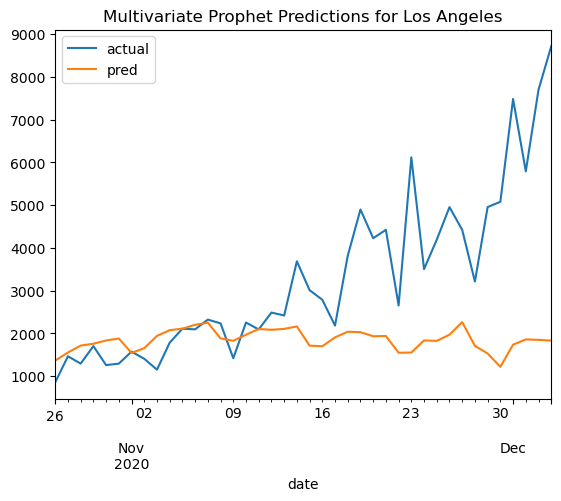

In [54]:
model=prophet.Prophet(holidays=events, holidays_prior_scale=0.01, changepoint_prior_scale=0.1, seasonality_prior_scale=0.1,
                                         seasonality_mode = 'additive',yearly_seasonality=True, weekly_seasonality=True)
model.add_country_holidays(country_name='US')
test.fillna(0, inplace=True)
train.fillna(0, inplace=True)
for ii in train.columns:
    if ii == 'index':
        continue
    if ii == 'ds':
        continue
    if ii == 'cases':
        continue
    if ii == 'y':
        continue
    model.add_regressor(ii)
model.fit(train)
pred = model.predict(test)


prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True), 
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = pd.to_datetime(test['ds'].reset_index(drop = True))
prediction.plot(x = 'date', y = ['actual', 'pred'], title='Multivariate Prophet Predictions for Los Angeles')

In [55]:
mean_absolute_percentage_error(prediction[prediction['actual'] != 0].actual, prediction[prediction['actual'] != 0].pred)

0.39138229656342344

In [56]:
train

,ds,cases,average_grade_performance,mean_temp,min_temp,max_temp,dewpoint,sea_level_pressure,station_pressure,visibility,...,max_temp_3d_avg,min_temp_3d_avg,dewpoint_3d_avg,y,stay_at_home_announced_no,stay_at_home_announced_yes,stay_at_home_effective_no,stay_at_home_effective_yes,"station_name_LOS ANGELES WHITEMAN AIRPORT, CA US",precip_flag_I
0,2020-03-10,20,0.0,61.9,55.4,66.2,52.5,0.0,980.8,8.8,...,67.4,53.6,47.000000,1.0,True,False,True,False,True,False
1,2020-03-11,28,0.0,62.9,57.2,68.0,52.8,0.0,980.7,9.5,...,66.8,54.2,51.566667,8.0,True,False,True,False,True,False
2,2020-03-12,32,0.0,57.2,50.0,66.2,49.4,0.0,976.3,7.9,...,62.6,52.4,50.833333,4.0,True,False,True,False,True,False
3,2020-03-13,40,0.0,51.0,50.0,53.6,50.3,0.0,976.9,2.8,...,58.4,50.6,50.800000,8.0,True,False,True,False,True,False
4,2020-03-14,53,0.0,53.6,51.8,55.4,52.7,0.0,982.7,5.7,...,55.4,51.8,48.866667,13.0,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,2020-10-21,290486,0.0,68.6,57.2,75.2,58.2,0.0,975.1,5.5,...,74.6,59.6,57.500000,477.0,False,True,False,True,True,True
226,2020-10-22,294065,0.0,65.7,62.6,68.0,56.4,0.0,0.0,6.5,...,70.4,60.8,55.866667,3579.0,False,True,False,True,True,True
227,2020-10-23,296821,0.0,65.8,62.6,68.0,53.0,0.0,0.0,9.8,...,68.0,62.6,54.533333,2756.0,False,True,False,True,True,True
228,2020-10-24,298937,0.0,65.2,62.6,68.0,54.2,0.0,980.0,8.8,...,67.4,61.4,52.400000,2116.0,False,True,False,True,True,True
